In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.misc
import numpy as np
import caffe
import cv2
import skfmm
import PIL.Image

import lib.imageutl as imutl
import lib.visualizationutl as view
%matplotlib inline

In [2]:
from caffe import layers as L
from caffe import params as P

def create_arq():
   
    n = caffe.NetSpec()
    n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='carLoaderLayer', 
          param_str='{"src_file": "../db/car", "batch_size":2, "im_shape":100 }' ), ntop=2)
    n.tdata, n.tlabel = L.Python(n.data, n.label, python_param = dict(module='caffelayerpython', layer='augmentationLayer', 
          param_str='{"angle":10, "translation":0.2, "warp":0 }' ), ntop=2)
    
    return 'name: "FCNnet"\n' + str(n.to_proto())

with open('train.prototxt', 'w') as f:
    f.write(create_arq());

#print arq
print(create_arq())


name: "FCNnet"
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "label"
  python_param {
    module: "caffelayerpython"
    layer: "carLoaderLayer"
    param_str: "{\"src_file\": \"../db/car\", \"batch_size\":2, \"im_shape\":100 }"
  }
}
layer {
  name: "tdata"
  type: "Python"
  bottom: "data"
  bottom: "label"
  top: "tdata"
  top: "tlabel"
  python_param {
    module: "caffelayerpython"
    layer: "augmentationLayer"
    param_str: "{\"angle\":10, \"translation\":0.2, \"warp\":0 }"
  }
}



In [4]:
caffe.set_mode_cpu()
net = caffe.Net('train.prototxt', caffe.TRAIN)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (2, 3, 100, 100)),
 ('label', (2, 1, 100, 100)),
 ('tdata', (2, 3, 100, 100)),
 ('tlabel', (2, 1, 100, 100))]

['tlabel', 'tdata']
(2, 3, 100, 100)
(2, 1, 100, 100)


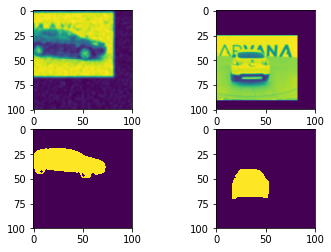

[ 0.  1.]


In [7]:
out = net.forward();
print(out.keys())

images = out['tdata'];
labels = out['tlabel'];

print(images.shape)
print(labels.shape)

plt.subplot(221)
plt.imshow(images[0,0,:,:])
plt.subplot(222)
plt.imshow(images[1,0,:,:])
plt.subplot(223)
plt.imshow(labels[0,0,:,:]==1)
plt.subplot(224)
plt.imshow(labels[1,0,:,:]==1)
plt.show()

print( np.unique(labels[1,0,:,:]) )


(100, 100, 3)


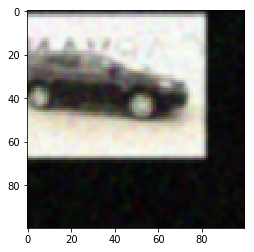

In [11]:

im = images[0,...].transpose(1,2,0);

print(im.shape)
plt.imshow(im)
plt.show()


In [12]:
caffe.set_mode_cpu()
net = caffe.Net('train_net.prototxt', caffe.TRAIN)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (2, 3, 512, 512)),
 ('label', (2, 1, 512, 512)),
 ('data_data_0_split_0', (2, 3, 512, 512)),
 ('data_data_0_split_1', (2, 3, 512, 512)),
 ('tdata', (2, 3, 512, 512)),
 ('tlabel', (2, 1, 512, 512)),
 ('tlabel_tdata_1_split_0', (2, 1, 512, 512)),
 ('tlabel_tdata_1_split_1', (2, 1, 512, 512)),
 ('data_preprocessed', (2, 3, 512, 512)),
 ('conv1', (2, 96, 176, 176)),
 ('pool1', (2, 96, 88, 88)),
 ('norm1', (2, 96, 88, 88)),
 ('conv2', (2, 256, 88, 88)),
 ('pool2', (2, 256, 44, 44)),
 ('norm2', (2, 256, 44, 44)),
 ('conv3', (2, 384, 44, 44)),
 ('conv4', (2, 384, 44, 44)),
 ('conv5', (2, 256, 44, 44)),
 ('pool5', (2, 256, 22, 22)),
 ('fc6', (2, 4096, 17, 17)),
 ('fc7', (2, 4096, 17, 17)),
 ('score_fr', (2, 2, 17, 17)),
 ('upscore', (2, 2, 575, 575)),
 ('score', (2, 2, 512, 512)),
 ('score_score_0_split_0', (2, 2, 512, 512)),
 ('score_score_0_split_1', (2, 2, 512, 512)),
 ('loss', ()),
 ('dice', (1,))]

In [13]:
out = net.forward();
print(out.keys())
print(out['loss'])
print(out['dice'])

['loss', 'dice']
0.689783215523
[ 0.]


In [8]:
# https://github.com/BVLC/caffe/wiki/Solver-Prototxt
solver = caffe.AdamSolver('solver.prototxt');
solver.net.copy_from('fcn_alexnet.caffemodel');


In [3]:
solver.step(1)

In [4]:
train_loss = solver.net.blobs['loss'].data
train_dice = solver.net.blobs['dice'].data
#score = solver.net.blobs['score_score_0_split_1'].data
#p = np.argmax(score, axis=1)
print(train_loss)
print(train_dice)

0.692066371441
[ 0.]


In [9]:
%%time
niter = 1000
test_interval = 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
train_dice = np.zeros(niter)

test_acc = np.zeros(int(np.ceil(niter / test_interval)))
#output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    
    solver.step(1)  # Adam by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    train_dice[it] = solver.net.blobs['dice'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    #solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        #correct = 0
        solver.test_nets[0].forward()
        acc = solver.test_nets[0].blobs['accuracy'].data;
        test_acc[it // test_interval] = acc;
        
        #for test_it in range(100):
        #    solver.test_nets[0].forward()
        #    #correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
        #    #               == solver.test_nets[0].blobs['label'].data)
        #    correct += solver.test_nets[0].blobs['accuracy'].data;
        #test_acc[it // test_interval] = correct / 1e2


Iteration 0 testing...
Iteration 10 testing...
Iteration 20 testing...
Iteration 30 testing...
Iteration 40 testing...
Iteration 50 testing...
Iteration 60 testing...
Iteration 70 testing...
Iteration 80 testing...
Iteration 90 testing...
Iteration 100 testing...
Iteration 110 testing...
Iteration 120 testing...
Iteration 130 testing...
Iteration 140 testing...
Iteration 150 testing...
Iteration 160 testing...
Iteration 170 testing...
Iteration 180 testing...
Iteration 190 testing...
Iteration 200 testing...
Iteration 210 testing...
Iteration 220 testing...
Iteration 230 testing...
Iteration 240 testing...
Iteration 250 testing...
Iteration 260 testing...
Iteration 270 testing...
Iteration 280 testing...
Iteration 290 testing...
Iteration 300 testing...
Iteration 310 testing...
Iteration 320 testing...
Iteration 330 testing...
Iteration 340 testing...
Iteration 350 testing...
Iteration 360 testing...
Iteration 370 testing...
Iteration 380 testing...
Iteration 390 testing...
Iteration 4

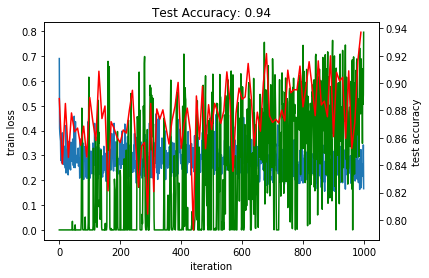

In [13]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax1.plot(np.arange(niter), train_dice,'g')
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
plt.show()

In [14]:
#print(train_dice)
#print(train_loss)
#print(solver.test_nets[0].blobs['dice'].data)

In [2]:
from caffe import layers as L
from caffe import params as P

def create_arq():
   
    n = caffe.NetSpec()
    n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='carLoaderLayer', 
          param_str='{"src_file": "../db/car", "batch_size":2, "im_shape":1024 }' ), ntop=2)
    n.tdata, n.tlabel = L.Python(n.data, n.label, python_param = dict(module='digitspythonlayer', layer='augmentationLayer', 
          param_str='{"size":1024, "angle":10, "translation":0.2, "warp":0 }' ), ntop=2)
    #n.tdata = L.Python(n.data, python_param = dict(module='digitspythonlayer', layer='resizeLayer', 
    #      param_str='{"size":500 }' ), ntop=1)
    
    return 'name: "FCNnet"\n' + str(n.to_proto())

with open('train.prototxt', 'w') as f:
    f.write(create_arq());

#print arq
print(create_arq())

name: "FCNnet"
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "label"
  python_param {
    module: "caffelayerpython"
    layer: "carLoaderLayer"
    param_str: "{\"src_file\": \"../db/car\", \"batch_size\":2, \"im_shape\":1024 }"
  }
}
layer {
  name: "tdata"
  type: "Python"
  bottom: "data"
  bottom: "label"
  top: "tdata"
  top: "tlabel"
  python_param {
    module: "digitspythonlayer"
    layer: "augmentationLayer"
    param_str: "{\"size\":1024, \"angle\":10, \"translation\":0.2, \"warp\":0 }"
  }
}



In [3]:
caffe.set_mode_cpu()
net = caffe.Net('train.prototxt', caffe.TEST)
[(k, v.data.shape) for k, v in net.blobs.items()]


[('data', (2, 3, 1024, 1024)),
 ('label', (2, 1, 1024, 1024)),
 ('tdata', (2, 3, 1024, 1024)),
 ('tlabel', (2, 1, 1024, 1024))]

171
255
['tlabel', 'tdata']
(2, 3, 1024, 1024)
(2, 1, 1024, 1024)


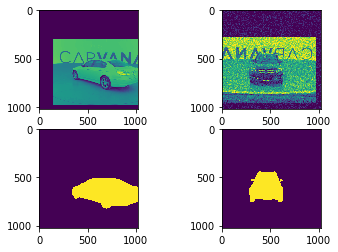

In [18]:
out = net.forward();
print(out.keys())

images = out['tdata'];
labels = out['tlabel'];

print(images.shape)
print(labels.shape)

plt.subplot(221)
plt.imshow(images[0,0,:,:])
plt.subplot(222)
plt.imshow(images[1,0,:,:])
plt.subplot(223)
plt.imshow(labels[0,0,:,:]==1)
plt.subplot(224)
plt.imshow(labels[1,0,:,:]==1)
plt.show()

#print( np.unique(labels[1,0,:,:]) )
#print( np.unique(images[0,0,:,:]) )
#print( np.unique(images[1,0,:,:]) )


(1024, 1024, 3)
255


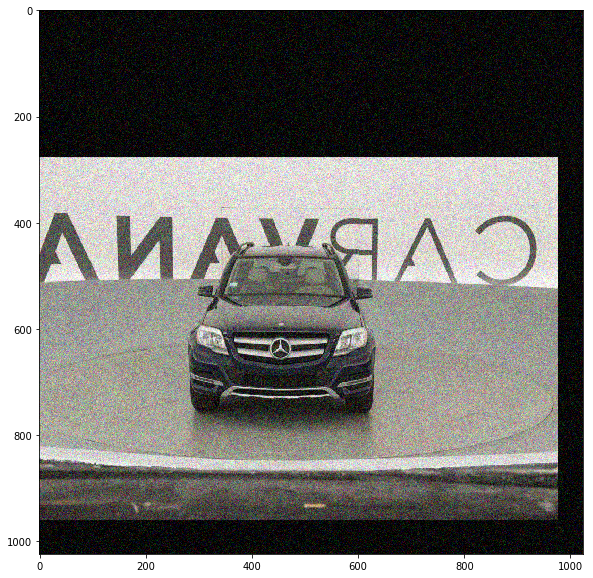

In [19]:
im = images[1,...].transpose(1,2,0).astype(np.uint8) ;

print(im.shape)
print(np.max(im))

plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.show()

#plt.imshow(im)
#plt.show()